# Querying useless neurons - performance

> TODO: use the same networks/scaling/sizes as the eval performance notebook!
> Plot them against eachother.

The useless neurons query is more bulky than our `eval` query, so it makes sense
to look at its performance characteristics separately. We'll look at the query's
performance from different points of view again:

- How does the performance scale with the number of hidden layers?
- How does the performance scale with the number of hidden nodes?
- How does the performance scale with the number of input vectors?

Note that much of this notebook is similar to that of [eval performance
overview](./1.6%20Eval%20-%20Performance.ipynb).

## Preliminaries

In [13]:
import utils.duckdb as db
import random
import matplotlib.pyplot as plt
import numpy as np
import utils.perftest as perftest
import pandas as pd

The useless neuron overview query:

In [14]:
with open('queries/useless_neurons_from_input.sql') as file:
    query = file.read()

We also compare it to the eval query performance, so we'll need that as well:

In [15]:
with open('queries/eval_recursive_from_input.sql') as file:
    eval_query = file.read()

Some code to set up the database:

In [16]:
def reset_db():
    db._initialize_database()

And the same utility function from [the eval performance
overview](./1.6%20Eval%20-%20Performance.ipynb) to create a random network, and
one to create random input values:

In [17]:
def create_network(num_input_nodes, num_nodes_per_layer, num_hidden_layers, num_output_nodes):
    def nodes():
        node_id = 1

        for i in range(0, num_input_nodes):
            yield [node_id, 0, f"input.{i}"]
            node_id += 1

        for layer in range(0, num_hidden_layers):
            for i in range(num_nodes_per_layer):
                bias = random.uniform(-10, 10)
                yield [node_id, bias, f"layer_{layer}.{i}"]
                node_id += 1

        for i in range(0, num_output_nodes):
            bias = random.uniform(-10, 10)
            yield [node_id, bias, f"output.{i}"]
            node_id += 1

    def edges():
        # Insert edges from input nodes to first hidden layer
        for i_from in range(0, num_input_nodes):
            for i_to in range(num_input_nodes, num_input_nodes + num_nodes_per_layer):
                from_node_id = i_from + 1
                to_node_id = i_to + 1
                weight = random.uniform(-10, 10)
                yield [from_node_id, to_node_id, weight]

        # Insert edges between hidden nodes
        for layer in range(0, num_hidden_layers - 1):
            for i_from in range(0, num_nodes_per_layer):
                for i_to in range(0, num_nodes_per_layer):
                    from_node_id = num_input_nodes + (layer * num_nodes_per_layer) + i_from + 1
                    to_node_id = num_input_nodes + ((layer + 1) * num_nodes_per_layer) + i_to + 1
                    weight = random.uniform(-10, 10)
                    yield [from_node_id, to_node_id, weight]

        # And finally, insert edges from the last hidden layer to the output nodes
        for i_from in range(0, num_nodes_per_layer):
            for i_to in range(0, num_output_nodes):
                from_node_id = num_input_nodes + ((num_hidden_layers - 1) * num_nodes_per_layer) + i_from + 1
                to_node_id = num_input_nodes + (num_hidden_layers * num_nodes_per_layer) + i_to + 1
                weight = random.uniform(-10, 10)
                yield [from_node_id, to_node_id, weight]

    db.batch_insert(nodes(), "node")
    db.batch_insert(edges(), "edge")

def create_random_input(num_input_nodes, num_input_sets):
    def input_generator():
        for input_set_id in range(0, num_input_sets):
            for input_node_idx in range(0, num_input_nodes):
                yield [input_set_id, input_node_idx, random.uniform(-10, 10)]


    db.con.execute("TRUNCATE TABLE input")
    df = pd.DataFrame(input_generator())
    db.con.execute(f"INSERT INTO input SELECT * FROM df")

## Scaling the number of hidden layers

We create a neural network with random weights and biases, increasing the number
of layers in each iteration. We also immediately collect timings for the regular
`eval` query as well, since we want to see how they compare relative to each
other.

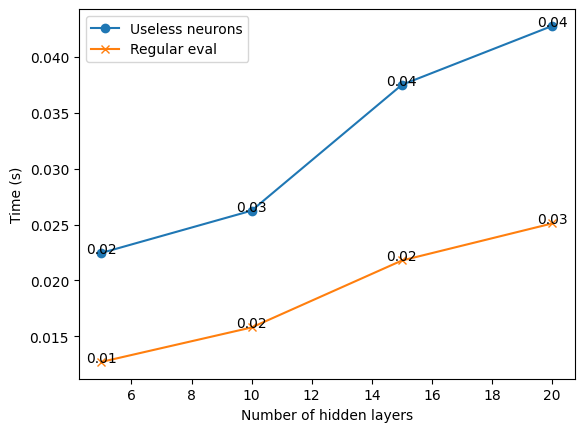

In [18]:
class HiddenLayersBase(perftest.PerfTest):
    def setup_run(self, hidden_layers):
        reset_db()
        create_network(
            num_input_nodes=2,
            num_nodes_per_layer=3,
            num_hidden_layers=hidden_layers,
            num_output_nodes=2
        )
        create_random_input(2, 1)

    def x_labels(self):
        return [5, 10, 15, 20]

class UselessHiddenLayersUseless(HiddenLayersBase):

    def run(self, hidden_layers):
        results = db.con.execute(query)

# TODO: use the values from the previous notebook, we have them.
#       Using the same name should suffice.
class UselessHiddenLayersEval(HiddenLayersBase):
    def run(self, hidden_layers):
        results = db.con.execute(eval_query)


df_useless = perftest.measure_performance(UselessHiddenLayersUseless())
df_eval = perftest.measure_performance(UselessHiddenLayersEval())

perftest.plot_dfs(
    [
        (df_useless, "Useless neurons", "o"),
        (df_eval, "Regular eval", "x")
    ],
    "Number of hidden layers"
)

We can see that the useless neuron query still scales linearly with the number
of hidden layers, but performs noticeably worse than the `eval` query.

## Scaling the number of hidden nodes

Now instead of increasing the number of hidden layers, we'll use a fixed amount
(10) and scale up the number of hidden nodes in each layer.

In [19]:
%%script echo TODO: rewrite

useless_timings = []
eval_timings = []

def measure_performance(num_nodes_per_layer):
    print(f"Querying {num_nodes_per_layer}...")

    reset_db()
    create_network(
        num_input_nodes=2,
        num_nodes_per_layer=num_nodes_per_layer,
        num_hidden_layers=10,
        num_output_nodes=2
    )
    create_random_input(2, 1)

    start = time.time()
    output = con.sql(query).fetchall()
    end = time.time()
    useless_timings.append(end - start)

    start = time.time()
    output = con.sql(eval_query).fetchall()
    end = time.time()
    eval_timings.append(end - start)

for num_nodes_per_layer in range(1, 11):
    measure_performance(num_nodes_per_layer * 10)

TODO: rewrite


In [20]:
%%script echo TODO: rewrite

xs = range(1, 11)
y1 = useless_timings
y2 = eval_timings

bar_width = 0.35
index = np.arange(len(xs))

plt.bar(index, y1, bar_width, label='Useless neurons query time')
plt.bar(index + bar_width, y2, bar_width, label='Eval query time')

plt.xlabel('Number of hidden nodes per layer (x10)')
plt.ylabel('Execution time (s)')
plt.title('Query performance - Useless neurons vs eval')

plt.xticks(index + bar_width / 2, xs)
plt.legend()
plt.show()

TODO: rewrite


We can see a drastic difference between the two queries. The useless query
overview seems to scale quadratically with the number of hidden nodes per layer.

## Scaling the number of input vectors

Let's also look at how our query performs when we increase the number of input
vectors that we evaluate in one go. We'll take a reasonably small neural network
with 5 hidden layers, 50 hidden nodes per layer, 784 input nodes, and 10 output
nodes. The input and output nodes correspond to the MNIST dataset, which has
28x28 images of 10 different classes (the digits).

In [21]:
%%script echo TODO: rewrite

# Our network is static, so we only need to create it once.
reset_db()
create_network(
    num_input_nodes=784,
    num_nodes_per_layer=50,
    num_hidden_layers=5,
    num_output_nodes=10
)

TODO: rewrite


In [22]:
%%script echo TODO: rewrite

useless_timings = []
eval_timings = []

def measure_performance(num_input_sets):
    print(f"Querying {num_input_sets}...")

    # TODO: this doesn't match the amount of input nodes (2 vs 784)
    create_random_input(2, num_input_sets)

    start = time.time()
    output = con.sql(query).fetchall()
    end = time.time()
    useless_timings.append(end - start)

    start = time.time()
    output = con.sql(eval_query).fetchall()
    end = time.time()
    eval_timings.append(end - start)

    return end - start

for num_input_sets in range(1, 11):
    measure_performance(num_input_sets * 10)

TODO: rewrite


In [23]:
%%script echo TODO: rewrite

xs = range(1, 11)
y1 = useless_timings
y2 = eval_timings

bar_width = 0.35
index = np.arange(len(xs))

plt.bar(index, y1, bar_width, label='Useless neurons query time')
plt.bar(index + bar_width, y2, bar_width, label='Eval query time')

plt.xlabel('Number of input vectors (x10)')
plt.ylabel('Execution time (s)')
plt.title('Query performance - Useless neurons vs eval')

plt.xticks(index + bar_width / 2, xs)
plt.legend()
plt.show()

TODO: rewrite


We see linear scaling again for the number of input vectors, but we perform
significantly worse than the regular `eval` query.